In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from models import Classifier, PGDAttackDetector
from eval_utils import BaseDetectorFactory, load_mnist_data, load_fashion_data
from eval_utils import get_adv_errors, get_nat_accs
from models import Detector

from sklearn.metrics import roc_auc_score

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.logging.set_verbosity(tf.logging.ERROR)

np.random.seed(123)


In [2]:
(x_train_outclass, y_train_outclass), (x_test_outclass, y_test_outclass) = load_mnist_data()
(x_train_inclass, y_train_inclass), (x_test_inclass, y_test_inclass) = load_fashion_data()

In [3]:
classifier = Classifier(var_scope='classifier', dataset='MNIST')
classifier_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                    scope='classifier')
classifier_saver = tf.train.Saver(var_list=classifier_vars, max_to_keep=1)

target_class = 3

detector_var_scope = 'detector-class{}'.format(target_class)
detector = Detector(var_scope=detector_var_scope)
detector_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 
                                  scope=detector_var_scope)
detector_savers = tf.train.Saver(var_list=detector_vars)

In [4]:
sess = tf.Session()

In [7]:
# classifier_saver.restore(sess, 'checkpoints/mnist/classifier')
detector_checkpoint = 'checkpoints/fashion/detector_Linf_0.5/ovr-steps100-adam-noclip-balanced/ovr_class{}_Linf_distance0.5-35'.format(target_class)
detector_savers.restore(sess, detector_checkpoint)

in class samples 1000, logit out mean 2.4571123123168945
out class samples 10000, logit out mean -1.6621350049972534
auc score: 0.8943732000000001


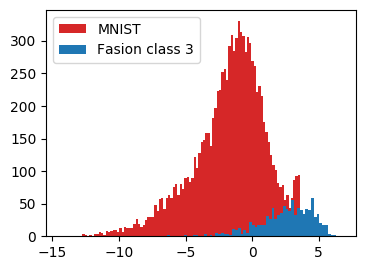

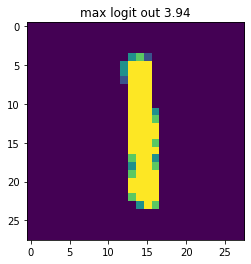

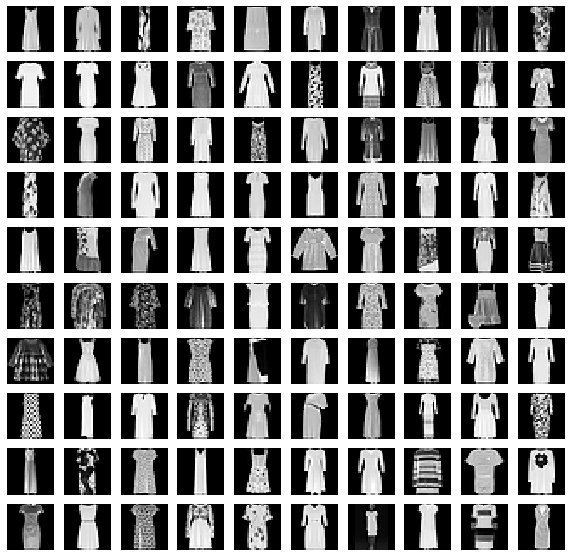

In [8]:
in_class_logit_out = sess.run(detector.logits, feed_dict={detector.x_input:x_test_inclass[y_test_inclass==target_class]})
out_class_logit_out = sess.run(detector.logits, feed_dict={detector.x_input:x_test_outclass})
print('in class samples {}, logit out mean {}'.format(in_class_logit_out.shape[0], in_class_logit_out.mean()))
print('out class samples {}, logit out mean {}'.format(out_class_logit_out.shape[0], out_class_logit_out.mean()))


y_true = np.concatenate([np.ones(in_class_logit_out.shape[0]), np.zeros(out_class_logit_out.shape[0])])
y_scores = np.concatenate([in_class_logit_out, out_class_logit_out])
print('auc score: {}'.format(roc_auc_score(y_true, y_scores)))

bins = 100
plt.figure(figsize=(4, 3), dpi=100)
plt.hist(out_class_logit_out, color='tab:red', bins=bins, label='MNIST')
plt.hist(in_class_logit_out, color='tab:blue', bins=bins, label='Fasion class {}'.format(target_class))
plt.legend();
plt.show()
plt.imshow(x_test_outclass[np.argmax(out_class_logit_out)].reshape([28, 28]))
plt.title('max logit out {:.2f}'.format(np.max(out_class_logit_out.max())))
plt.show()

# fig, axes = plt.subplots(ncols=10, figsize=(10, 1))
# for im, ax in zip(x_test_inclass[y_test_inclass==target_class], axes):
#     ax.imshow(im.reshape([28, 28]))
#     ax.set_axis_off()
# plt.show()


fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
for im, ax in zip(x_test_inclass[y_test_inclass==target_class], axes.ravel()):
    ax.imshow(im.reshape([28, 28]), cmap='gray')
    ax.set_axis_off()
plt.show()

in class samples 1000, logit out mean 2.4571123123168945
out class samples 10000, logit out mean -60.36497497558594
auc score: 1.0


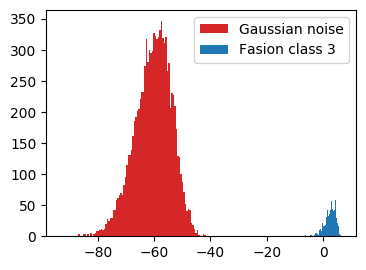

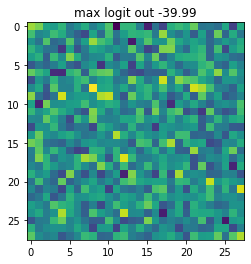

In [9]:
rand_x_test_outclass = np.random.randn(*x_test_outclass.shape)
in_class_logit_out = sess.run(detector.logits, feed_dict={detector.x_input:x_test_inclass[y_test_inclass==target_class]})
out_class_logit_out = sess.run(detector.logits, feed_dict={detector.x_input:rand_x_test_outclass})
print('in class samples {}, logit out mean {}'.format(in_class_logit_out.shape[0], in_class_logit_out.mean()))
print('out class samples {}, logit out mean {}'.format(out_class_logit_out.shape[0], out_class_logit_out.mean()))


y_true = np.concatenate([np.ones(in_class_logit_out.shape[0]), np.zeros(out_class_logit_out.shape[0])])
y_scores = np.concatenate([in_class_logit_out, out_class_logit_out])
print('auc score: {}'.format(roc_auc_score(y_true, y_scores)))

bins = 100
plt.figure(figsize=(4, 3), dpi=100)
plt.hist(out_class_logit_out, color='tab:red', bins=bins, label='Gaussian noise')
plt.hist(in_class_logit_out, color='tab:blue', bins=bins, label='Fasion class {}'.format(target_class))
plt.legend()
plt.show()
plt.imshow(rand_x_test_outclass[np.argmax(out_class_logit_out)].reshape([28, 28]))
plt.title('max logit out {:.2f}'.format(np.max(out_class_logit_out.max())))
plt.show()


In [10]:
x_test = x_test_outclass[:100]
attack_config = {
    'max_distance': 200,
    'num_steps': 100,
    'step_size': 0.1,
    'random_start': False,
    'x_min': 0,
    'x_max': 1.0,
    'batch_size': x_test.shape[0],
    'optimizer': 'adam',
    'norm': 'L2'
}


attack = PGDAttackDetector(detector=detector, **attack_config)
x_test_adv = attack.perturb(x_test, np.zeros(x_test.shape[0]), sess)


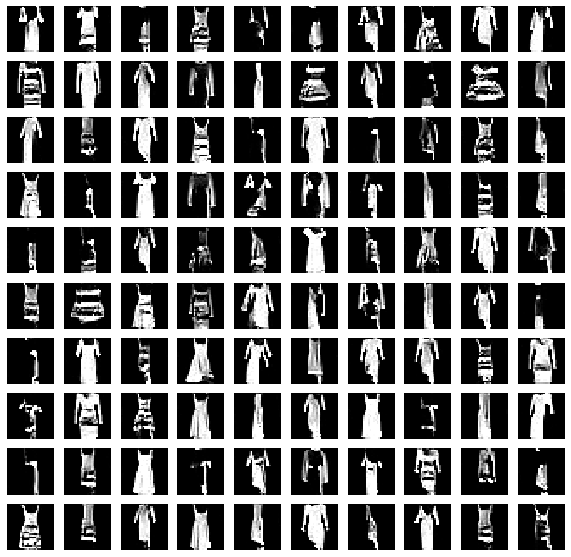

In [11]:
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
for im, ax in zip(x_test_adv, axes.ravel()):
    ax.imshow(im.reshape([28, 28]), cmap='gray')
    ax.set_axis_off()
plt.show()

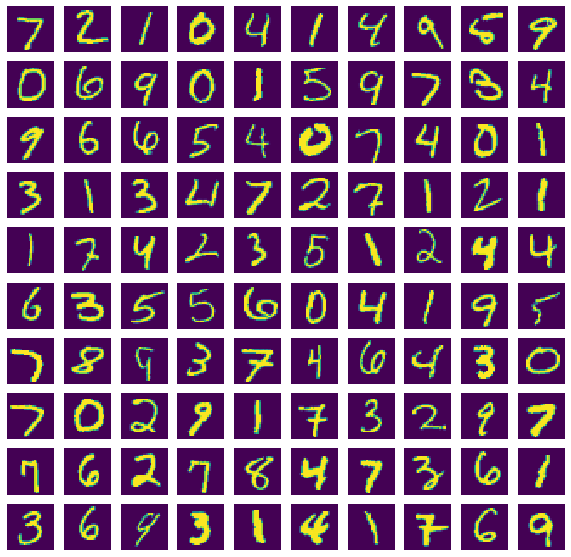

In [12]:
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
for im, ax in zip(x_test, axes.ravel()):
    ax.imshow(im.reshape([28, 28]))
    ax.set_axis_off()
plt.show()